# Training a neural network to fit curves to claims data

This Jupyter notebook describes a new method of fitting curves to claims data. The curves it produces are for use in frequency-severity modelling of insurance claims. However this is an experimental technique which requires further refining before it is suitable for use in actual insurance modelling work.

The method involves training a neural network to curve-fit a, 4-parameter, cubic Bézier curve to claims severity data. The resulting trained neural network accepts claims severity data as input, and will output predicted best estimate Bézier parameters.

The complete Python code is provided below, and will run on any Jupyter server configured with the required Tensorflow libraries. 

Steps covered:

  1. The generation of randomised cubic Bézier curves that satisfy the requirements of probabilistic cumulative distribution functions.
  
  1. Creation of a labelled training set of synthetic data by random sampling from Bézier curves.
  
  1. The training of a regression neural network on the synthetic data to provide best estimates of the Bézier parameters.

  1. Using the trained neural network to produce curve fits to real data.

  1. A discussion of the strengths, limitations and further applications of the method.


## Install and import the various python libraries we will use

In [ ]:
# install the libraries we need
# Note that Tensorflow is likely to need further configuration beyond the pip install shown below
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install h5py
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import random
import tensorflow as tf
import h5py

##  Curve fitting overview

Claim modelling in actuarial work often involves fitting smooth parametric curves to actual claims data. Using smooth parametric curves provide a way of extrapolating from a limited set of loss data to a complete range of losses.

It is common practice in General Insurance to model claims frequency and severity separately using Monte Carlo modelling techniques. This provides a straightforward way to model non-linear insurance contract features.

A number of different probability distributions are used to approximate claims data. A common feature is that they are often skewed distributions, reflecting the same skewed, or 'fat-tailed', distributions often observed in real insurance claims.

Examples of commonly used distributions include: [Pareto](https://en.wikipedia.org/wiki/Pareto_distribution), [Lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution), [Beta](https://en.wikipedia.org/wiki/Beta_distribution), and [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution)

**Example Cumulative Distribution Functions (CDFs)**

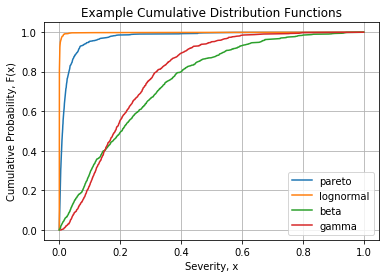

In [3]:
# plot examples of different cumulative distribution functions
# the parameters of each distribution have been hardcoded here but can be changed 
n= 1000
xvals_pareto = np.random.pareto(2, n) 
xvals_pareto.sort()
xvals_pareto = xvals_pareto /xvals_pareto[-1]

xvals_lognormal = np.random.lognormal(1.5,3,n ) 
xvals_lognormal.sort()
xvals_lognormal = xvals_lognormal /xvals_lognormal[-1]

xvals_beta = np.random.beta(1,4,n)
xvals_beta.sort()
xvals_beta = xvals_beta /xvals_beta[-1]
              
xvals_gamma = np.random.gamma(2, 2,n) 
xvals_gamma.sort()
xvals_gamma = xvals_gamma /xvals_gamma[-1]

yvals = np.arange(0,n,1)/n
plt.plot(xvals_pareto,yvals, label='pareto')
plt.plot(xvals_lognormal,yvals, label='lognormal')
plt.plot(xvals_beta,yvals, label='beta')
plt.plot(xvals_gamma,yvals, label='gamma')
plt.title('Example Cumulative Distribution Functions')
plt.xlabel('Severity, x')
plt.ylabel('Cumulative Probability, F(x)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Curve Fitting Issues

A typical approach to curve fitting involves selecting a parametric probability distribution and using the actual claims data to fit appropriate paramaters. for example using a [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) approach. 

Common issues are: 
  1. Judgement is needed to select the distribution family likely to provide the best fit to the data
  1. A need to use [Least Squares](https://en.wikipedia.org/wiki/Least_squares) or other goodness-of-fit tests to compare multiple distribution families
  1. Obtaining curves on the full range of values you are interested in - so avoiding issues of unbounded severity - or curve fits only available above a given threshold
  1. Working with real world data that does not have a natural fit to any of the common distribution families

## What could a useful claims severity solution look like?

A useful curve fitting technique might have the following features:
  1. Produce smooth parametric distributions that can be described by a small number of parameters
  1. Provide severity values in the range (0,1) - to be applied to maxmium exposure amounts to generate monnetary losses
  1. No pre-knowledge of the underlying distribution family should be required
  1. Provide a good fit to a wide range of real world claims data, without the need to compare goodness-of-fit across different distribution families
  1. Offers a simple method of generating means, standard deviations and other statistics
  1. Allow measurement of the confidence in the goodness-of-fit
  


## Bézier Curves

[Bezier curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve) have been used in graphic design since the 1960s, originally for car design and more recently in computer graphics. 
Some previous research has been done in using Bézier curves as probability distributions. Relevant examples include: [Wagner and Wilson (1996)](https://people.engr.ncsu.edu/jwilson/files/wagner96iie.pdf) and [Torres-Jimenez and Montenegro-Diaz (2017)](https://arxiv.org/pdf/1709.05534.pdf). We will be considering cubic-bezier curves bounded between (0,1) on both the x and y axes using the explicit form of the curve:

$
\begin{equation*}
B(t) = \left(1 - t\right)^3P_0 + 3\left(1 - t\right)^2tP_1 + 3\left(1 - t\right)t^2P_2 + t^3P_3, 0 \leq t \leq 1
\end{equation*}
$

We will set $\begin{equation*} P_0 =(0,0) \end{equation*}$ and $\begin{equation*} P_3 =(1,1) \end{equation*}$

### Code to render our cubic Bézier's

First we define a simple 'Point' class to make it easier to work with x and y coordinates, and a second 'ArrayData' class to convert from a list of Point's to a list of x and y's that will make plotting charts easier.

In [4]:
class Point():
	"""simple class for x y coordinates"""
	def __init__(self,x,y):
		self.x = x
		self.y = y		
	
	def __add__(self,other):
		return Point(self.x+other.x,self.y+other.y)
	
	def __mul__(self,other):
		return Point(self.x*other,self.y*other)
	
	__rmul__ = __mul__

class ArrayData():
	"""simple class for easier array access"""
	
	def __init__(self,object_array):
		"""convert an array of point objects into an array for plot"""
		self.x=[]
		self.y=[]
		for item in object_array:
			self.x.append(item.x)
			self.y.append(item.y)

Then we define some functions to get x and y points from a Bezier curve using a [Bisection method](https://en.wikipedia.org/wiki/Bisection_method)

In [5]:
def get_x_from_t(p0,p1,p2,p3,t):
	"""get the x value given t is known"""
	xy = ((1-t)**3)*p0 + (3*(1-t)**2)*t*p1 + 3*(1-t)*(t**2)*p2 + (t**3)*p3
	return xy.x
	
def get_y_from_t(p0,p1,p2,p3,t):
	"""get the y value given t is known"""
	xy = ((1-t)**3)*p0 + (3*(1-t)**2)*t*p1 + 3*(1-t)*(t**2)*p2 + (t**3)*p3
	return xy.y	
	
def get_x_from_y(p0,p1,p2,p3,y):
    """bisection method to get x given a y"""
    # we set an aribitrary level of accuracy
    accuracy= 0.0000001
    t_low=0
    t_high=1
    while True:
        t = (t_low+t_high)/2
        trial_y = get_y_from_t(p0,p1,p2,p3,t)
        if(abs(trial_y-y)<accuracy):
            break
        if(trial_y<y): 
            t_low = t
        else:
            t_high= t
    return get_x_from_t(p0,p1,p2,p3,t)

Let's write another function to plot Bezier curves and sampled loss data:

In [6]:
def buildcurve(p0,p1,p2,p3,x_vals=[]):
    """a function to plot a beaier curve and, if provided, an array of sampled data"""
    bezier = lambda t: ((1-t)**3)*p0 + (3*(1-t)**2)*t*p1 + 3*(1-t)*(t**2)*p2 + (t**3)*p3
    xy_arr = np.zeros((2, 1000))
    for t in range(1000):
        this_xy = bezier(t/1000)
        xy_arr[0][t] = this_xy.x
        xy_arr[1][t] = this_xy.y
    
    # Add scatter plot sample data
    x_vals = list(filter(lambda a: abs(a) > 0.0000001, x_vals))
    spacing =len(x_vals)
    x_vals = np.array(x_vals)
    x_vals.sort()
    y_vals = np.arange(1, (spacing+1), 1)/(spacing+1)
    
    # plot the data
    fig = plt.figure()
    ax = plt.axes()
    ax.axis([0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('F(x)')
    ax.plot(xy_arr[0],xy_arr[1])
    ax.plot(p0.x,p0.y,'or', label='P0')
    ax.plot(p1.x,p1.y,'or', label='P1')
    ax.plot(p2.x,p2.y,'or', label='P2')
    ax.plot(p3.x,p3.y,'or', label='P3')
    ax.plot(x_vals,y_vals,'og', label='Point Data')
    ax.annotate('P0 =(%.0f,%.0f)' % (p0.x , p0.y), xy=(p0.x , p0.y), xytext=(5, 5),textcoords ='offset pixels')
    ax.annotate('P1 =(%.2f,%.2f)' % (p1.x , p1.y), xy=(p1.x , p1.y), xytext=(5, 0),textcoords ='offset pixels')
    ax.annotate('P2 =(%.2f,%.2f)' % (p2.x , p2.y), xy=(p2.x , p2.y), xytext=(5, 0),textcoords ='offset pixels')
    ax.annotate('P3 =(%.0f,%.0f)' % (p3.x , p3.y), xy=(p3.x , p3.y), xytext=(5, 5),textcoords ='offset pixels')
    plt.show()

Now we can define our  $\begin{equation*} P_0,P_1,P_2,P_3 \end{equation*}$ points and take a look at some randomly generated curves

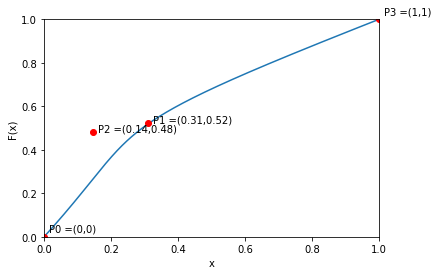

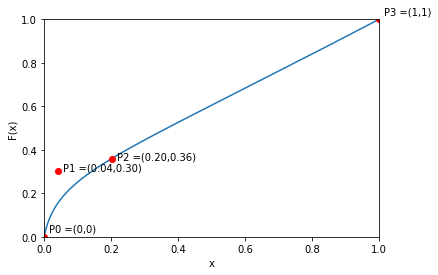

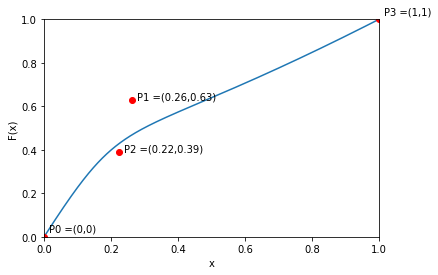

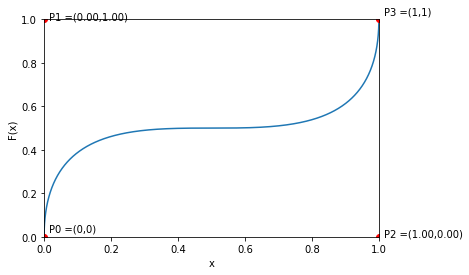

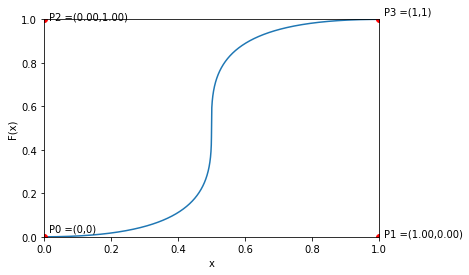

In [7]:
p0 = Point(0,0)
p3 = Point(1,1)

for i in range(3):
    p1 = Point(random.random(),random.random())
    p2 = Point(random.random(),random.random())
    buildcurve(p0,p1,p2,p3)

# generating some extremes
p1 = Point(0,1)
p2 = Point(1,0)
buildcurve(p0,p1,p2,p3)
p1 = Point(1,0)
p2 = Point(0,1)
buildcurve(p0,p1,p2,p3)

## Using Bézier curves as Distribution Functions

These randomly constructed Bézier curves give us functions that appear to satisfy the requirements of a cummulative distribution function $\begin{equation*} F_X\left(x\right) = P\left(X \leq x \right)  \end{equation*}$
  1. defined for $\begin{equation*}0 \leq x \leq 1 \end{equation*}$
  2. smooth curve
  3. monotonically  increasing (for right choices of $\begin{equation*}P_1 \end{equation*}$ and $\begin{equation*}P_2 \end{equation*}$)
 
 

We can take random samples from these curves to produce a random set of $\begin{equation*} \left(x,F_X\left(x\right)\right)\end{equation*}$.

Taking $\begin{equation*}F_X\left(x\right) = y\end{equation*}$ we can refer to our random points as  $\begin{equation*} \left(x,y\right)\end{equation*}$.

We will now write a function to create random samples from a set of randomly generated Bézier curves. 


In [8]:
def generate_data(number_bezier,number_samples):
    """takes the number of curves required and maximum number of samples from each curve as inputs and returns a random data set"""
    data_set=[]
    for i in range(number_bezier):
        p1 = Point(random.random(),random.random())
        p2 = Point(random.random(),random.random())  
        retvalues =[0]*number_samples
        for j in range(0,int(number_samples*random.random())):
            #compute values of x (severity) given different random y (cdf)
            y = random.random()
            x = get_x_from_y(p0,p1,p2,p3,y)
            retvalues[j]=x
        data_set.append([p1.x, p1.y,p2.x, p2.y] + retvalues)
    return data_set

Now we can generate data sets of any size as needed. As an example here we will generate four random Bézier curves with up to 50 randomly sampled values.
Note that we are plotting these by sorting the sampled values and assuming they are uniformly spaced between  $\begin{equation*}0 \leq F_X\left(x\right) \leq 1\end{equation*}$

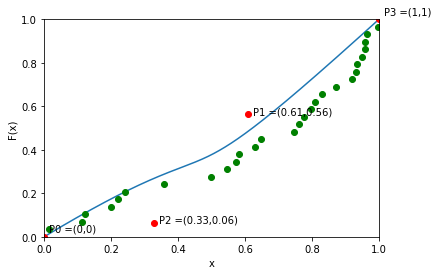

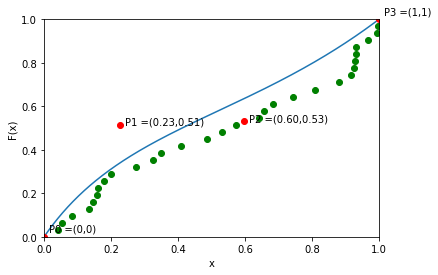

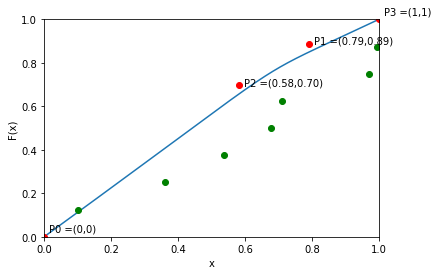

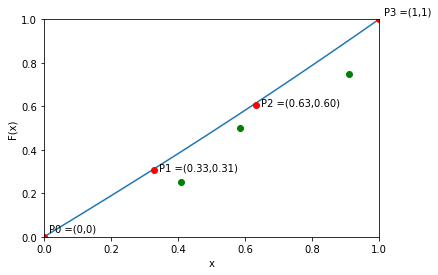

In [9]:
data_set=generate_data(4,50)
for i in range(len(data_set)):
    buildcurve(p0,Point(data_set[i][0],data_set[i][1]),Point(data_set[i][2],data_set[i][3]),p3,data_set[i][4:])


## Creating a large data set

Now we create a large data set to train and test a neural network. 
We will write this data set to disk to save time later on. 

We will read the data set from the file when it's time to train our neural network.

Let's create a dataset of 500,000 items, each item having up to 500 random samples.

In [ ]:
# Saved as a 'raw' cell as this is time consuming to run - change to a 'code' cell to execute
sample_size = 500
# the total number of records we want to create
total_size = 500000
# the number of chunks to break this into - to avoid running out of memory
size_per_set = 1000

# create an empty file
data_set = np.zeros(shape = (0,sample_size+4) )

# h5py is a useful library for reading/writing large numpy arrays to disk
with h5py.File('bezier_data.hdf5', 'w') as hf:
    dset = hf.create_dataset('bezier', data=data_set,maxshape=(None, sample_size+4))

# now execute it
for j in range(int(total_size/size_per_set)):
    data_set = generate_data(size_per_set,sample_size)
    #convert to a numpy array
    print('appending batch %d' % (j))
    data_set = np.array(data_set) 
    with h5py.File('bezier_data.hdf5', 'a') as hf:
        hf["bezier"].resize((hf["bezier"].shape[0] + data_set.shape[0]), axis =0) 
        hf["bezier"][-data_set.shape[0]:] = data_set

print('finished generating data set')

## Training a neural network

Now that we have a labelled dataset of sampled data (inputs) and their corresponding Bézier curve parameters (outputs), we can use it to train a regression neural network. 

A portion of our data will be held back and used only for evaluation (not training).

We will use a neural network with an input layer of 500 input nodes (allowing up to 500 claim inputs), a first hidden layer with 240 nodes, a second hidden layer with 12 nodes, a third hidden layer with 8 nodes, and an output layer with 4 nodes (corresponding to $\begin{equation*}P_1\left(x\right), P_1\left(y\right), P_2\left(x\right), P_2\left(y\right) \end{equation*}$).

We will use Tensorflow to implement the training and will use sigmoid activation functions and batch training.

![Neural Network](Nn.jpeg)

To avoid running out of computer memory we will batch train our model directly from the large data file we wrote to disk. We will break it into 10 pieces. 

One of these will be used for evaluation and the other nine for training. 

First we prepare our data for tensorflow: The first of the nine chunks will be used to compute the data's statistical mean values and to normalise the whole data set.

In [10]:
# we load in our data
hf = h5py.File('bezier_data.hdf5', 'r')
np_data = hf.get('bezier')

# Chunk size
total_train_chunks = 9
output_nodes = 4
total_size = np_data.shape[0]
sample_size = np_data.shape[1] - output_nodes
test_size = int(total_size/(total_train_chunks+1))
train_size = total_size - test_size
chunk = int(train_size/total_train_chunks)

# using the 10'th chunk as test data
y_test = np_data[train_size:total_size,0:output_nodes]
x_test = np_data[train_size:total_size,output_nodes:(output_nodes+sample_size)]

# we will normalise all data based on the means from the first chunk of the data
y_train = np_data[0:chunk,0:output_nodes]
x_train = np_data[0:chunk,output_nodes:(output_nodes+sample_size)]

# normalise the data, all inputs and outputs already bounded by 0,1
y_mean = np.mean(y_train,axis=0)
x_mean = np.mean(x_train,axis=0)

# we define some function to normalise and de-normalise the data
def normalise_x(x):
    return x - x_mean

def normalise_y(y):
    return y - y_mean
    
def denormalise_x(x):
    return x + x_mean

def denormalise_y(y):
    return y + y_mean

x_test = normalise_x(x_test)
y_test = normalise_y(y_test)

x_train = normalise_x(x_train)
y_train = normalise_y(y_train)


# This is a key parameter - the hidden layer structure we will use in our neural network
nn_hidden = [240,12,8]

Now we train the neural network in batches - we're going to do multiple passes (epochs) through the full training data:

In [ ]:
# we generate a random string to record the data as we train
model_path = './tmp/regression_' + str(int(random.random()*1000000))
# define the other settings for tensorflow
feature_columns = [tf.feature_column.numeric_column(key="x", shape=sample_size)]

# each step will pass through a batch of 20 random samples
feed_batch_size = 20
total_epochs = 100
predict_input_fn = tf.estimator.inputs.numpy_input_fn({"x": x_test}, num_epochs=1, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn({"x": x_test}, y_test, batch_size=feed_batch_size, num_epochs=1, shuffle=True)

# we are using the tensorflow pre-built DNNRegressor, this requires a warmstart to record training progress into tensorboard
for j in range(total_epochs):
    for i in range(total_train_chunks):
        print ('processing chunk %d' % (i))
        if ((i==0) and (j==0)):
            estimator = tf.estimator.DNNRegressor(feature_columns=feature_columns, hidden_units=nn_hidden, label_dimension=output_nodes, 
                                                  activation_fn=tf.nn.sigmoid, model_dir=model_path, 
                                                  config=tf.estimator.RunConfig().replace(save_summary_steps=10))        
        else:
            #continue training with the new batch of data using a 'warm start'
            estimator = tf.estimator.DNNRegressor(feature_columns=feature_columns, hidden_units=nn_hidden, label_dimension=output_nodes, 
                                                  activation_fn=tf.nn.sigmoid, 
                                                  model_dir=model_path,warm_start_from=model_path, 
                                                  config=tf.estimator.RunConfig().replace(save_summary_steps=10))
    
        # now we read in the next chunk of data
        y_train = np_data[chunk*i:chunk*(i+1),0:output_nodes]
        x_train = np_data[chunk*i:chunk*(i+1),output_nodes:(output_nodes+sample_size)]

        # and we normalise it pre-training 
        x_train = normalise_x(x_train)
        y_train = normalise_y(y_train)

        # define our tensorflow input function and run the train and evaluate steps
        train_input_fn = tf.estimator.inputs.numpy_input_fn({"x": x_train}, y_train, batch_size=feed_batch_size, num_epochs=1, shuffle=True)
        estimator.train(input_fn=train_input_fn, steps=int(x_train.shape[0]/feed_batch_size))
        estimator.evaluate(input_fn=eval_input_fn, steps=int(x_test.shape[0]/feed_batch_size))

## Optimising the neural network's learning performance

There are various ways to try and optimise the neural network's learning performance, a discussion of which is beyond the scope of this work. The features experimented with here were the number of nodes and the number of hidden layers. 

The chart below was taken from TensorBoard and shows the relative learning performance of various neural network configuations. 

Each neural network has a training line and a validation line. The final selected configuration was the network with three hidden layers described above.

![Tensorboard Learning rates](Learning_Curves.jpeg)

## Predictions from the trained model

Now that we have a trained model we can use it to curve fit to new data.

First we write a function that will load the weights of the trained model back into tensorflow. 
We can then pass in new loss data and receive predicted Bezier parameters. 

Let's create a new random data set to visualise the trained model's performance. 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecab0a4748>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_tf_random_seed': None, '_task_id': 0, '_save_summary_steps': 100, '_train_distribute': None, '_master': '', '_keep_checkpoint_max': 5}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-1365000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


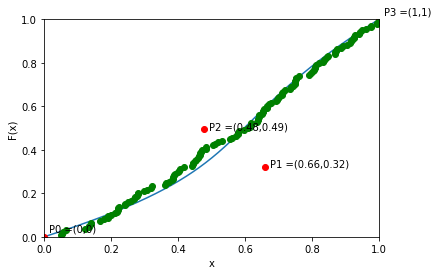

Predicted: P1=(0.66,0.32) P2=(0.48,0.49)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


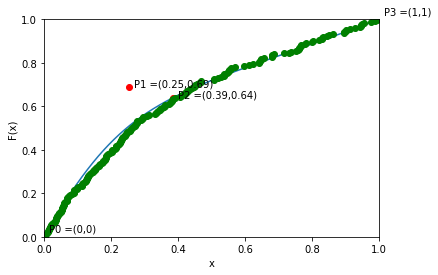

Predicted: P1=(0.25,0.69) P2=(0.39,0.64)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


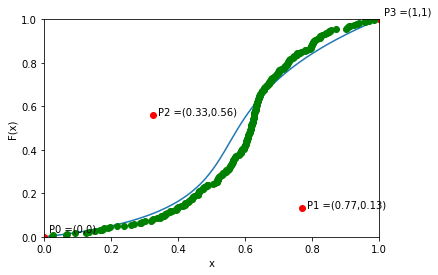

Predicted: P1=(0.77,0.13) P2=(0.33,0.56)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


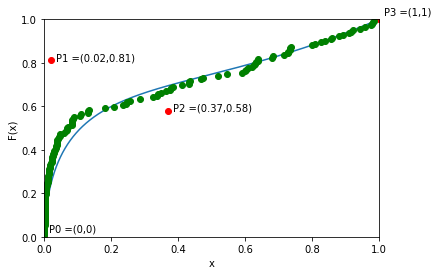

Predicted: P1=(0.02,0.81) P2=(0.37,0.58)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


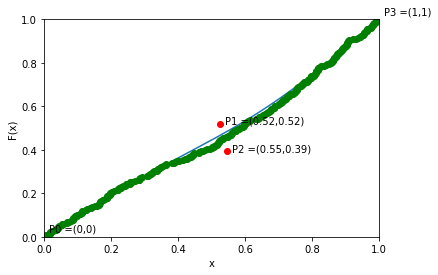

Predicted: P1=(0.52,0.52) P2=(0.55,0.39)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


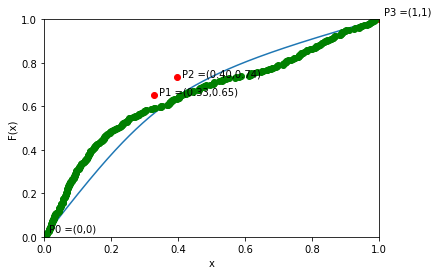

Predicted: P1=(0.33,0.65) P2=(0.40,0.74)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


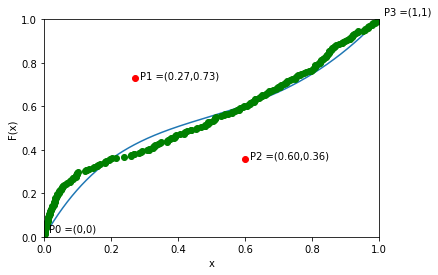

Predicted: P1=(0.27,0.73) P2=(0.60,0.36)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


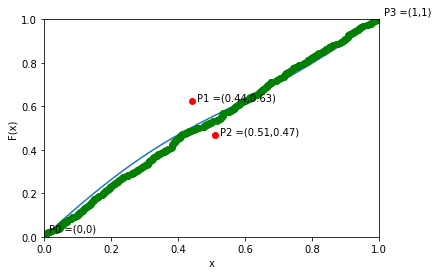

Predicted: P1=(0.44,0.63) P2=(0.51,0.47)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


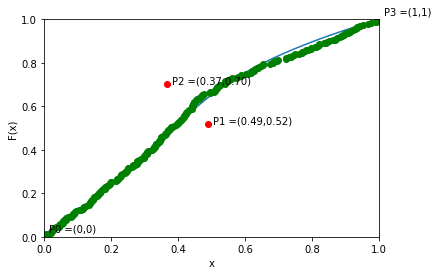

Predicted: P1=(0.49,0.52) P2=(0.37,0.70)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


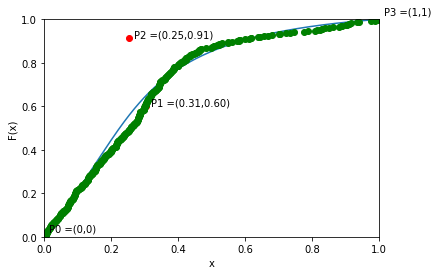

Predicted: P1=(0.31,0.60) P2=(0.25,0.91)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


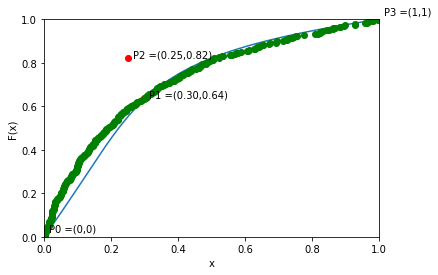

Predicted: P1=(0.30,0.64) P2=(0.25,0.82)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


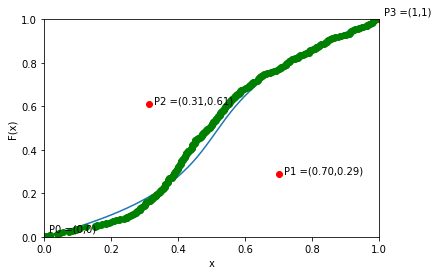

Predicted: P1=(0.70,0.29) P2=(0.31,0.61)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


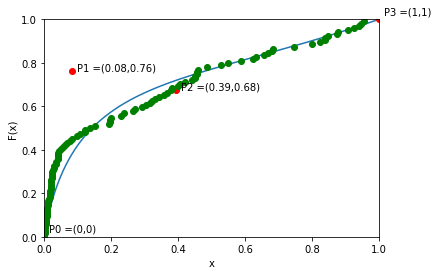

Predicted: P1=(0.08,0.76) P2=(0.39,0.68)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


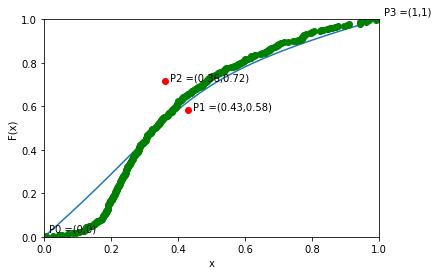

Predicted: P1=(0.43,0.58) P2=(0.36,0.72)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


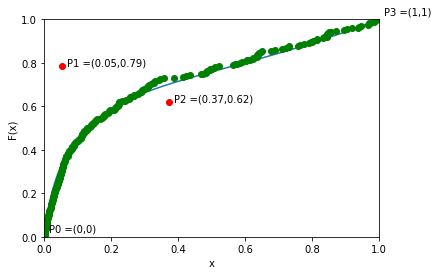

Predicted: P1=(0.05,0.79) P2=(0.37,0.62)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


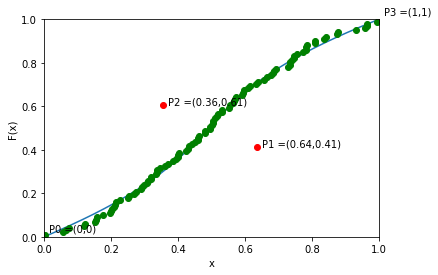

Predicted: P1=(0.64,0.41) P2=(0.36,0.61)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


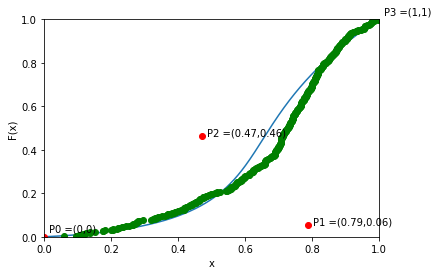

Predicted: P1=(0.79,0.06) P2=(0.47,0.46)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


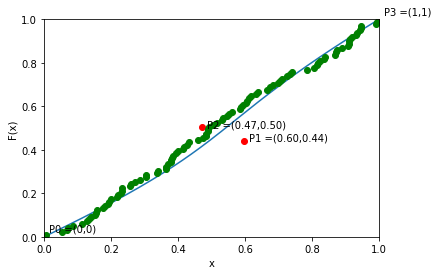

Predicted: P1=(0.60,0.44) P2=(0.47,0.50)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


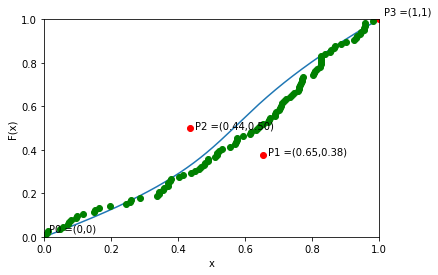

Predicted: P1=(0.65,0.38) P2=(0.44,0.50)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


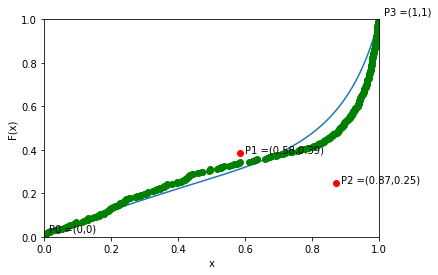

Predicted: P1=(0.58,0.39) P2=(0.87,0.25)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


In [16]:
#load pre-run model
feature_columns = [tf.feature_column.numeric_column(key="x", shape=sample_size)]
prerun = './tmp/regression_477366' 
estimator = tf.estimator.DNNRegressor(feature_columns=feature_columns, hidden_units=nn_hidden, label_dimension=output_nodes, 
                                      activation_fn=tf.nn.sigmoid, model_dir=prerun,warm_start_from=prerun)

def predict_bezier(loss_samples):
    loss_samples_n = normalise_x(loss_samples)
    """Take an array of up to 500 losses and return the Bezier points"""
    predict_input_fn = tf.estimator.inputs.numpy_input_fn({"x": loss_samples_n}, num_epochs=1, shuffle=False)
    results_gf = estimator.predict(input_fn=predict_input_fn)
    predict_points = np.empty((0,output_nodes))
    for i in results_gf:
        predict_points = np.vstack((predict_points, i['predictions']))    
    predict_points = denormalise_y(predict_points)
    #print (predict_points)
    #p1 = Point(predict_points[0,0],predict_points[0,1])
    #p2 = Point(predict_points[0,2],predict_points[0,3])
    return predict_points


# create random loss samples
n_examples = 20
new_data_set = np.array(generate_data(n_examples,sample_size))
y_new_actual = new_data_set[:,0:output_nodes]
x_new = new_data_set[:,output_nodes:(output_nodes+sample_size)]

y_new_predict = predict_bezier(x_new)
for i in range(n_examples):
    buildcurve(p0,Point(y_new_predict[i,0],y_new_predict[i,1]),Point(y_new_predict[i,2],y_new_predict[i,3]),p3,x_new[i])
    print('Predicted: P1=(%.2f,%.2f) P2=(%.2f,%.2f)' % (y_new_predict[i,0] ,y_new_predict[i,1],y_new_predict[i,2],y_new_predict[i,3]))
    print('Actual:    P1=(%.2f,%.2f) P2=(%.2f,%.2f)' % (y_new_actual[0][0] ,y_new_actual[0][1],y_new_actual[0][2],y_new_actual[0][3]))




## Next Steps

We now have a very basic model that will provide us with automated curve fits. Three future steps would be:
  1. Test prediction performance using sampled data from other statistical distributions
  1. Examine the performance on real data
  1. Further optimise the models learning ability. E.g. systematically adjusting the volumes of training data, network structure and other factors
 
  

## Limitations
The synthetic training data we have generated using uniform distributions might not be sufficiently skewed to provide a good fit to 'fat tailed' claims data. 

Further steps could be to investigate performance in fitting to a Pareto distribution with a low alpha (<1) parameter.

To achieve a better performance on extreme value distribtuions, we could try higher order Bezier curves, or a wider range of handle parameters (P1 and P2). Unfortunately this would likely result in some generated curves that break the monotonically increasing requirement of a CDF. Perhaps we could address this by introducing an additional screening step to remove any such curves from our training data.

The choice of curve used to train the model is likely to be critical to the models performance. Cubic Bezier curves were used here as they are easy to work with, and appear to provide a superfically good-fit to a wide range of distributions. However the same model could be trained using random selections from other traditional probability distributions (lognormal, pareto etc), or even a mix and match from multiple distribtuions.

In providing a value between zero and one the model would be useful in situations when the total policy exposure in insurance is capped. However there are examples of insurance classes that have no defined upper limit of exposure (UK Motor libaility for example).

## Strengths
The main strengths of the method are that it satisfies most of the criteria we discussed above:
  1. Produce smooth parametric distributions that can be described by a small number of parameters
  1. Provide severity values in the range (0,1) - to be applied to maxmium exposure amounts to generate monnetary losses
  1. No pre-knowledge of the underlying distribution family should be required
  1. Provide a good fit to a wide range of real world claims data, without the need to compare goodness-of-fit across different distribution families
  1. Offers a simple method of generating means, standard deviations and other statistics*
  1. Allow measurement of the confidence in the goodness-of-fit**

\*It is relatively strightforward to compute common statistical metrics from Bezier curves using numerical methods

\*\*An approach for measuring the confidence in the goodness-of-fit is discussed below.

## Further Applications - Measure of confidence
It is technically possible to extract the confidence of the neural network in its own predictions (although not covered here!).

This could probably be achieved using a set of four classifier (soft max) neural networks, with one trained for each Bezier output point.

The classifications used would be numerical bands, and the trained model output would be the probability distribution of the predicted parameter.